In [2]:
import gym
import random
import numpy as np
import bottleneck as bn

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from collections import namedtuple, deque
from torch.distributions import Categorical
import time
import pandas as pd

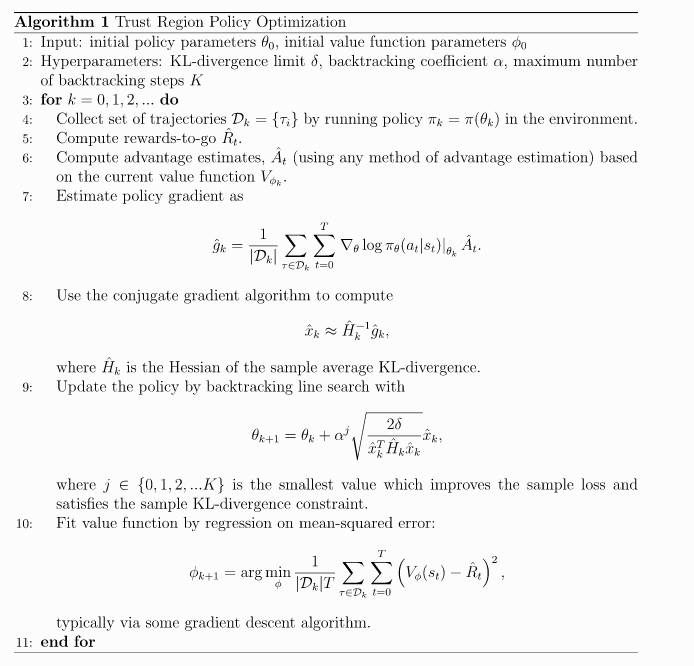

reference: https://github.com/g6ling/Reinforcement-Learning-Pytorch-Cartpole

Memory/Replay Buffer Class

In [3]:
Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

class Memory(object):
    def __init__(self):
        self.memory = deque()

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self):
        memory = self.memory
        return Transition(*zip(*memory)) 

    def __len__(self):
        return len(self.memory)


Utility Functions

In [4]:
def flat_grad(grads):
    grad_flatten = []
    for grad in grads:
        grad_flatten.append(grad.view(-1))
    grad_flatten = torch.cat(grad_flatten)
    return grad_flatten

def flat_hessian(hessians):
    hessians_flatten = []
    for hessian in hessians:
        hessians_flatten.append(hessian.contiguous().view(-1))
    hessians_flatten = torch.cat(hessians_flatten).data
    return hessians_flatten

def flat_params(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))
    params_flatten = torch.cat(params)
    return params_flatten

def update_model(model, new_params):
    index = 0
    for params in model.parameters():
        params_length = len(params.view(-1))
        new_param = new_params[index: index + params_length]
        new_param = new_param.view(params.size())
        params.data.copy_(new_param)
        index += params_length

def kl_divergence(policy, old_policy):
    kl = old_policy * torch.log(old_policy / policy)

    kl = kl.sum(1, keepdim=True)
    return kl

def fisher_vector_product(net, states, p, cg_damp=0.1):
    policy = net(states)
    old_policy = net(states).detach()
    kl = kl_divergence(policy, old_policy)
    kl = kl.mean()
    kl_grad = torch.autograd.grad(kl, net.parameters(), create_graph=True) # create_graph is True if we need higher order derivative products
    kl_grad = flat_grad(kl_grad)

    kl_grad_p = (kl_grad * p.detach()).sum()
    kl_hessian_p = torch.autograd.grad(kl_grad_p, net.parameters())
    
#     for i in kl_hessian_p:
#         if check_nan(i):
#             print("p",p)
#             print("policy",policy)
#             print("KL",kl)
#             print("KL_grad",kl_grad)
#             print("KL_grad_p",kl_grad_p)
#             print("KL_hessian_p",kl_hessian_p)
#             break

        
    kl_hessian_p = flat_hessian(kl_hessian_p)

    return kl_hessian_p + cg_damp * p.detach()


def conjugate_gradient(net, states, loss_grad, n_step=10, residual_tol=1e-10):
    x = torch.zeros(loss_grad.size())
    r = loss_grad.clone()
    p = loss_grad.clone()
    r_dot_r = torch.dot(r, r)

    for i in range(n_step): 
        A_dot_p = fisher_vector_product(net, states, p)
        alpha = r_dot_r / torch.dot(p, A_dot_p)
        x += alpha * p
        r -= alpha * A_dot_p
        new_r_dot_r = torch.dot(r,r)
        betta = new_r_dot_r / r_dot_r
        p = r + betta * p
        r_dot_r = new_r_dot_r
        if r_dot_r < residual_tol:
            break
    return x

def check_nan(x):
    return int(torch.isnan(x).sum())

Agent

In [5]:
class TRPO(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(TRPO, self).__init__()
        self.t = 0
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc_1 = nn.Linear(num_inputs, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.fc_3 = nn.Linear(64, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, input):
        x = torch.relu(self.fc_1(input))
        x = torch.relu(self.fc_2(x))
#         policy = F.softmax(self.fc_3(x),dim=-1)
        x = F.log_softmax(self.fc_3(x),dim=-1)

        return torch.exp(x)
    
    def check(self,input): #debug method
        print("Input: ", input)
        x = torch.relu(self.fc_1(input))
        x = torch.relu(self.fc_2(x))
#         policy = F.softmax(self.fc_3(x),dim=-1)
        print("Logit:",self.fc_3(x))
        #x = F.log_softmax(self.fc_3(x),dim=-1)
        print(vars(self.fc_1))
        print(vars(self.fc_2))
        print(vars(self.fc_3))

    @classmethod
    def train_model(cls, net, transitions):
        states, actions, rewards, masks = transitions.state, transitions.action, transitions.reward, transitions.mask

        states = torch.stack(states)
        actions = torch.stack(actions)
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)

        returns = torch.zeros_like(rewards)

        running_return = 0
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + gamma * running_return * masks[t]
            returns[t] = running_return

        policy = net(states)
        policy = policy.view(-1, net.num_outputs)
        policy_action = (policy * actions.detach()).sum(dim=1)

        old_policy = net(states).detach()
        old_policy = old_policy.view(-1, net.num_outputs)
        old_policy_action = (old_policy * actions.detach()).sum(dim=1)

        surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

        surrogate_loss_grad = torch.autograd.grad(surrogate_loss, net.parameters())
        surrogate_loss_grad = flat_grad(surrogate_loss_grad)

        step_dir = conjugate_gradient(net, states, surrogate_loss_grad.data)

        params = flat_params(net)
        shs = (step_dir * fisher_vector_product(net, states, step_dir)).sum(0, keepdim=True)
        
        
        step_size = torch.sqrt((2 * max_kl) / shs)[0]
            
        full_step = step_size * step_dir

        fraction = 1.0
        
        
        
        for _ in range(10): #Conduct line search 
            new_params = params + fraction * full_step
            
            update_model(net, new_params)
            policy = net(states)
            policy = policy.view(-1, net.num_outputs)
            policy_action = (policy * actions.detach()).sum(dim=1)
            surrogate_loss = ((policy_action / old_policy_action) * returns).mean()

            kl = kl_divergence(policy, old_policy)
            kl = kl.mean()

            if kl < max_kl: #if KL condition is violated
                break
            fraction = fraction * 0.5  #decay factor = 0.5

        return -surrogate_loss

    def get_action(self, input):
        try:
            policy = Categorical(self.forward(input))
#         policy = policy[0].data.numpy()
        
        except:
            print(self.forward(input))
            print("Nan occured, terminating")
            return -1
        
        action = policy.sample()
        
        return action


# CartPole

In [30]:
env_name = 'CartPole-v1'
gamma = 0.99
goal_score = 200
log_interval = 10
max_kl = 0.001

env = gym.make(env_name)
env.seed(500)
torch.manual_seed(500)

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
print('state size:', num_inputs)
print('action size:', num_actions)

net = TRPO(num_inputs, num_actions)
writer = SummaryWriter('logs')


running_score = 0
steps = 0
loss = 0
for e in range(2000):
    done = False
    memory = Memory()

    score = 0
    state = env.reset()
    state = torch.Tensor(state)
    state = state.unsqueeze(0)

    while not done:
        steps += 1

        action = net.get_action(state)
        next_state, reward, done, _ = env.step(action)

        next_state = torch.Tensor(next_state)
        next_state = next_state.unsqueeze(0)

        mask = 0 if done else 1
        reward = reward if not done or score == 499 else -1

        action_one_hot = torch.zeros(2)
        action_one_hot[action] = 1
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state

    loss = TRPO.train_model(net, memory.sample())

    score = score if score == 500.0 else score + 1
    running_score = 0.99 * running_score + 0.01 * score
    if e % log_interval == 0:
        print('{} episode | score: {:.2f}'.format(e, running_score))
        print("Average steps per episode:", steps/log_interval)
        steps = 0
        writer.add_scalar('log/score', float(running_score), e)
        writer.add_scalar('log/loss', float(loss), e)

    if running_score > goal_score:
        break

# Machine GMM 

In [6]:
from machine import Machine
from GymMachEnv import MachineEnv

In [7]:
gamma = 0.95
log_interval = 10 #every 10 episodes, update NN
max_kl = 0.001
#max_kl = 1e-06

In [8]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [10]:
net = TRPO(num_inputs, num_actions)

net.train()
#writer = SummaryWriter('./logs/TRPO_5')

best_score = 0
running_score = 0
Total_score = 0
steps = 0
loss = 0
maintenance_count = 0
score_repo = []

start_time = time.time()

torch.autograd.set_detect_anomaly(True) 

for e in range(10000):
    done = False
    memory = Memory()

    score = 0
    state = env.reset()
    state = torch.Tensor(state)
    state = state.unsqueeze(0)

    while not done:
        steps += 1

        action = net.get_action(state)
        
        if action == -1: break
            
        if action == 1: maintenance_count+=1
        
        next_state, reward, done, _ = env.step(action)

        next_state = torch.Tensor(next_state)
        next_state = next_state.unsqueeze(0)

        mask = 0 if done else 1

        action_one_hot = torch.zeros(2)
        action_one_hot[action] = 1
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state
    
    if action == -1: #check if gradient update exploded or error in gradients detected
        net.check(state)
        
        break
        
    loss = TRPO.train_model(net, memory.sample())

    Total_score+=score
    
    if e % log_interval == 0:
        score_repo.append([Total_score/log_interval,e])
            
        print('{} episode | Average score: {:.2f} | Average steps per episode: {}| Average number of maintenance: {}'.format(
            e, Total_score/log_interval,steps/log_interval, (maintenance_count/log_interval)))
        
#         writer.add_scalar('log/Average_score', float(Total_score/log_interval), e)
#         writer.add_scalar('log/Episode_length',float(steps/log_interval),e)
#         writer.add_scalar('log/Maintenance_count',float(maintenance_count/log_interval),e)
#         writer.add_scalar('log/loss', float(loss), e)
        
        Total_score = 0
        maintenance_count=0
        steps = 0
        
#         if best_score < running_score:
#             best_score = running_score
#             torch.save(net,'TRPO_agent.pt')

print("Total Execution Time: ",(time.time() - start_time)/60, " minutes")

0 episode | Average score: 920.00 | Average steps per episode: 1.8| Average number of maintenance: 0.7
10 episode | Average score: 22580.00 | Average steps per episode: 46.5| Average number of maintenance: 19.0
20 episode | Average score: 28230.00 | Average steps per episode: 56.1| Average number of maintenance: 22.9
30 episode | Average score: 9560.00 | Average steps per episode: 23.4| Average number of maintenance: 8.6
40 episode | Average score: 22410.00 | Average steps per episode: 42.8| Average number of maintenance: 14.9
50 episode | Average score: 15750.00 | Average steps per episode: 32.4| Average number of maintenance: 9.5
60 episode | Average score: 12090.00 | Average steps per episode: 25.1| Average number of maintenance: 6.2
70 episode | Average score: 13830.00 | Average steps per episode: 30.3| Average number of maintenance: 9.6
80 episode | Average score: 24130.00 | Average steps per episode: 44.0| Average number of maintenance: 13.5
90 episode | Average score: 19010.00 |

760 episode | Average score: 20290.00 | Average steps per episode: 39.0| Average number of maintenance: 12.5
770 episode | Average score: 17310.00 | Average steps per episode: 33.6| Average number of maintenance: 10.5
780 episode | Average score: 21750.00 | Average steps per episode: 41.3| Average number of maintenance: 13.4
790 episode | Average score: 18980.00 | Average steps per episode: 41.1| Average number of maintenance: 13.6
800 episode | Average score: 24610.00 | Average steps per episode: 47.1| Average number of maintenance: 15.9
810 episode | Average score: 22800.00 | Average steps per episode: 46.4| Average number of maintenance: 17.3
820 episode | Average score: 25830.00 | Average steps per episode: 49.3| Average number of maintenance: 15.8
830 episode | Average score: 21120.00 | Average steps per episode: 37.7| Average number of maintenance: 11.0
840 episode | Average score: 32560.00 | Average steps per episode: 58.9| Average number of maintenance: 20.0
850 episode | Avera

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\torch\autograd\__init__.py:234: UserWarning: Error detected in DivBackward0. Traceback of forward call that caused the error:
  File "C:\Users\overl\anaconda3\envs\env1\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\overl\anaconda3\envs\env1\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\overl\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\overl\anaconda3\envs\env1\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\overl\anaconda3\envs\env1\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\overl\anaconda3\envs\env1\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\overl\

RuntimeError: Function 'DivBackward0' returned nan values in its 1th output.

In [89]:
score_repo = np.array(score_repo)

In [1]:
score_repo

NameError: name 'score_repo' is not defined

# Test Trained Agent

In [5]:
agent = torch.load('TRPO_agent.pt')
agent.eval()

TRPO(
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=2, bias=True)
)